# Optimization: Methodologies in deep networks

In the last section we have covered how PyTorch autograd engine works in the optimization process.

Today we will cover some commonly used techniques usually used in deep networks to improve the optimization process:
- **Normalization techniques**: data normalization, batch normalization, layer normalization
- **Network parameter initialization**: Xavier initialization, Kaiming initialization
- **Learning rate scheduling**
- **Residual connections**

## 1. Normalization techniques

In a nutshell, normalization is a technique used to scale the features and transform the data distrbution to improve training.

Normalization techniques are used to stabilize the learning process and improve the convergence of the optimization process.

Today we will have a look at three normalization techniques:
- **Data normalization**: scaling the input data
- **Batch normalization**: normalizing the activations of a layer
- **Layer normalization**: normalizing the activations of a layer across the features

### 1.1 Data normalization
Sometimes you will see dataset that has one feature with a very large range of values, and another feature with a very small range of values.
This can cause problems since it will create an error surface that is very different across the dimensions.

A way to solve this is to rescale values that has $\mu = 0$ and $\sigma = 1$.

Let us see it in practice with a scikit-learn MLP!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)


# Generate synthetic dataset with different scales
def generate_synthetic_data(n_samples=1000):
    """
    Generate a synthetic dataset with two features having very different scales.
    Feature 1 ranges from 0 to 1
    Feature 2 ranges from 0 to 1000
    """
    # Generate two classes of data which has two dimensions with different scales
    n_class_0 = n_samples // 2
    X1_class_0 = np.random.normal(0.3, 0.1, n_class_0)
    X2_class_0 = np.random.normal(300, 100, n_class_0)

    n_class_1 = n_samples - n_class_0
    X1_class_1 = np.random.normal(0.7, 0.1, n_class_1)
    X2_class_1 = np.random.normal(700, 100, n_class_1)

    # Combine the features and create the labels
    X = np.vstack(
        [
            np.column_stack([X1_class_0, X2_class_0]),
            np.column_stack([X1_class_1, X2_class_1]),
        ]
    )
    y = np.hstack([np.zeros(n_class_0), np.ones(n_class_1)])

    # Shuffle the dataset
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y


# Generate data
X, y = generate_synthetic_data(1000)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

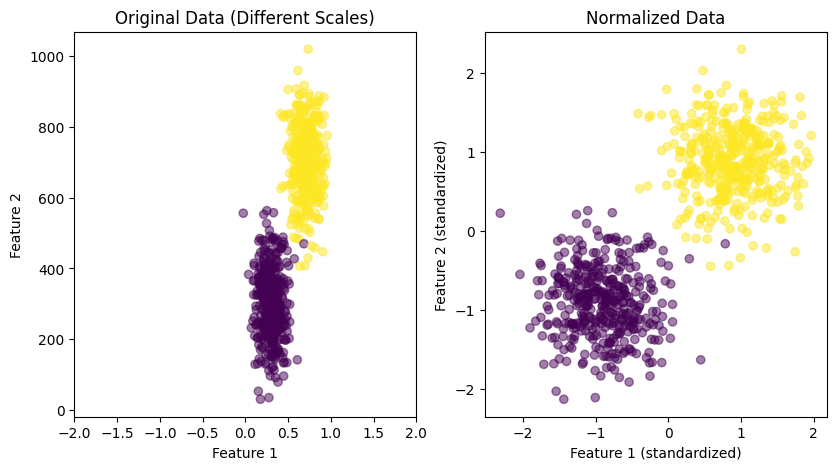

In [2]:
# Plot the original data
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="viridis", alpha=0.5)
plt.xlim(-2, 2)
plt.title("Original Data (Different Scales)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Now, let's standardize the data
# Create a standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Plot the normalized data
plt.subplot(1, 3, 2)
plt.scatter(
    X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap="viridis", alpha=0.5
)
plt.title("Normalized Data")
plt.xlabel("Feature 1 (standardized)")
plt.ylabel("Feature 2 (standardized)")
plt.show()

Note that even we have used -2~2 for the display range for the original data, it is still very skewed (it will look like a vertical line when we use feature2's scale for feature1).

> 🤔 **THINKING**
>
> - Based on your knowledge about optimization, what do you think will happen if we run SGD on the original data?

Now let us compare two MLP models on the dataset with and without normalization.

In scikit-learn the training will automatically stop after convergence.

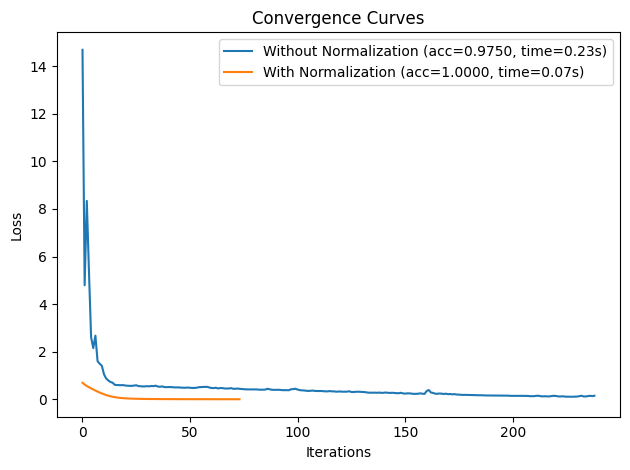

In [3]:
import time

# Define MLP parameters
mlp_params = {
    "hidden_layer_sizes": (100, 50),
    "activation": "relu",
    "solver": "adam",
    "alpha": 0.0001,
    "batch_size": "auto",
    "learning_rate": "adaptive",
    "max_iter": 1000,
    "random_state": 42,
}

# Train MLP without normalization
start_time = time.time()
mlp_without_norm = MLPClassifier(**mlp_params)
mlp_without_norm.fit(X_train, y_train)
without_norm_time = time.time() - start_time
y_pred_without_norm = mlp_without_norm.predict(X_test)
accuracy_without_norm = accuracy_score(y_test, y_pred_without_norm)

# Train MLP with normalization
start_time = time.time()
mlp_with_norm = MLPClassifier(**mlp_params)
mlp_with_norm.fit(X_train_scaled, y_train)
with_norm_time = time.time() - start_time
y_pred_with_norm = mlp_with_norm.predict(X_test_scaled)
accuracy_with_norm = accuracy_score(y_test, y_pred_with_norm)

plt.plot(
    mlp_without_norm.loss_curve_,
    label=f"Without Normalization (acc={accuracy_without_norm:.4f}, time={without_norm_time:.2f}s)",
)
plt.plot(
    mlp_with_norm.loss_curve_,
    label=f"With Normalization (acc={accuracy_with_norm:.4f}, time={with_norm_time:.2f}s)",
)
plt.title("Convergence Curves")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

> 🤔 **THINKING**
>
> - What did you observe regarding the convergence speed of the two models?

### 1.2 Batch normalization and layer normalization

Batch normalization and layer normalization are two other normalization techniques used to improve the training of deep neural networks. They could be seen as natural extensions of the data normalization technique, where the target of normalization is the variable in **each hidden layer**.

- Batch normalization normalizes the inputs of each layer across the batch dimension (i.e. take EACH FEATURE from the samples and calculate the stats with respect to THIS FEATURE)

- Layer normalization normalizes the inputs of each layer across the feature dimension (i.e. normalize INSIDE EACH SAMPLE INPUT, and each input sample is normalized independently of the others)

An instinct of where batch norm and layer norm are used is that batch norm is mostly used in convolutional networks, while layer norm is mostly used in recurrent networks & transformers.
One of the reason is that layer norm normalizes within each example independently, making it better suited for sequential data and variable-length inputs.

We can check this by looking at the architecture of the models.

In [4]:
import torchvision

resnet = torchvision.models.resnet18(weights="DEFAULT")
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

> 🤔 **THINKING**
>
> - Find the `BatchNorm2d` layer in the ResNet architecture. Where is it usually located in the layer sequences?

> 📚 **EXERCISE**
>
> - Vision transformers (ViT) are a new architecture that is used in computer vision and is based on transformers. Try to load one and inspect its architecture like we have just done. What kind of normalization is used in the architecture?

In [5]:
# === Your code here ===

## 2. Network parameter initialization

Although PyTorch has done it implicitly for you, 
do notice that the parameter in our neural network are not initialized by random,
but by some rules based on sophisticated mathematical analysis.

Proper initialization ensures well-behaved activations and gradients, which in turn leads to better optimization process.

Let us have a peek into it by looking at the easiest layer: `nn.Linear`.

In [6]:
import torch


# Define a function to visualize the weights' histogram
def plot_linear_layer_hist(layer: torch.nn.Module):
    """
    Plot the histogram of the weights of a linear layer.
    """
    weights = layer.weight.data.cpu().numpy()  # type: ignore
    plt.hist(weights.flatten(), bins=50, density=True)
    plt.title(f"Histogram of Weights for {layer.__class__.__name__}")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.show()

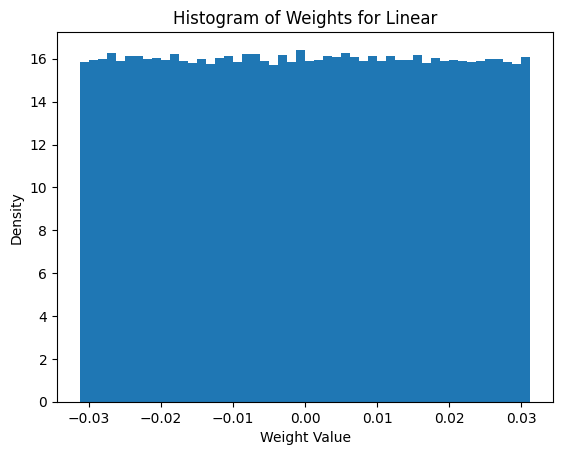

In [7]:
lin_default = torch.nn.Linear(1024, 512)
plot_linear_layer_hist(lin_default)

Did you observe a uniform distribution? This is because default initialization is done by
$$
w \sim U(-\sqrt{k}, \sqrt{k}), k = \frac{1}{in\_features}
$$
where $in\_features$ is the number of input features.

In [8]:
print(1 / np.sqrt(1024))

0.03125


Indeed! 🎉

Besides the default initialization, there are two other common initialization methods:
- **Xavier initialization**, usually used for `tanh` and `sigmoid` activations
- **Kaiming initialization**: used for `ReLU` activations

Let's see one in practice. The module related to initialization is `torch.nn.init`.

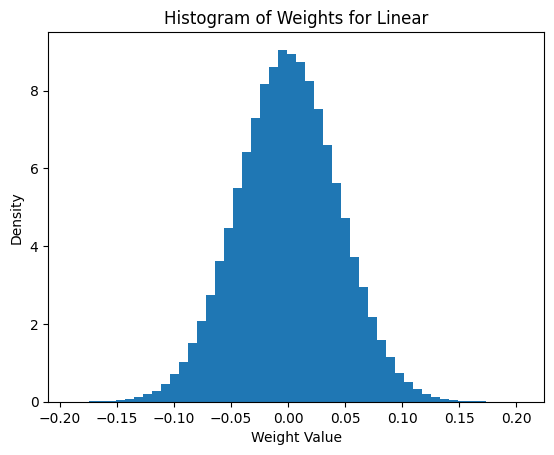

In [9]:
# The method with a trailing underscore means in-place operation
lin_kaiming_normal = torch.nn.Linear(1024, 512)
torch.nn.init.kaiming_normal_(lin_kaiming_normal.weight)
plot_linear_layer_hist(lin_kaiming_normal)

The mathematical proof for the initialization requires sophisticated mathematics and is beyond the scope of this hands-on.

If you are interested, here are some references for mathematics lovers :3
- [PyTorch - Xavier initialization](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_)
- [PyTorch - Kaiming initialization](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_)
- (ICCV '15) [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852), where Kaiming initialization was introduced

## 3. Learning rate scheduling

Remember in the last notebook we have set the learning rate to a fixed value?

Actually, you do not need to do so. A dynamic learning rate is a common practice in deep learning as it has potentially better performance when navigating on the complicated error surface.

In PyTorch, such dynamic learning rate is implemented in the `torch.optim.lr_scheduler` module by wrapping the optimizer.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR, StepLR

# Setup parameters
epochs = 500
initial_lr = 0.1

# Create schedulers
# The optimizer is a placeholder with dummy parameter. Replace it with your actual optimizer in real training.
step_scheduler = StepLR(
    torch.optim.SGD([torch.zeros(1)], lr=initial_lr), step_size=20, gamma=0.5
)
exp_scheduler = ExponentialLR(
    torch.optim.SGD([torch.zeros(1)], lr=initial_lr), gamma=0.97
)
cosine_scheduler = CosineAnnealingLR(
    torch.optim.SGD([torch.zeros(1)], lr=initial_lr), T_max=20, eta_min=0.001
)

In [11]:
# Track learning rates
def get_lrs(scheduler, epochs):
    lrs = []
    for _ in range(epochs):
        lrs.append(scheduler.get_last_lr()[0])
        scheduler.step()
    return lrs

In [12]:
# PyTorch will warn you if you did not step the optimizer before calling the scheduler. We can ignore this warning for the sake of this example.
import warnings

warnings.filterwarnings("ignore")

step_lrs = get_lrs(step_scheduler, epochs)
exp_lrs = get_lrs(exp_scheduler, epochs)
cosine_lrs = get_lrs(cosine_scheduler, epochs)

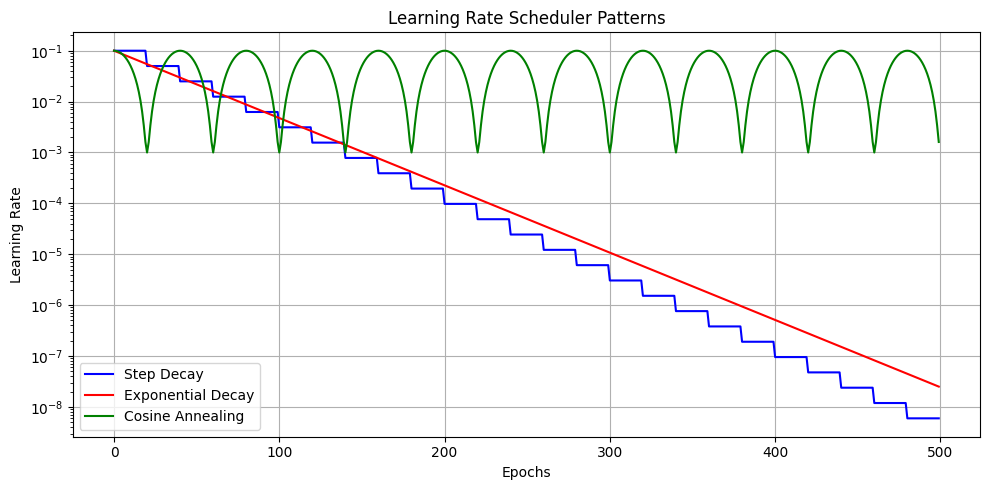

In [13]:
# Plot the learning rate schedules
plt.figure(figsize=(10, 5))
epochs_range = range(epochs)

plt.plot(epochs_range, step_lrs, "b-", label="Step Decay")
plt.plot(epochs_range, exp_lrs, "r-", label="Exponential Decay")
plt.plot(epochs_range, cosine_lrs, "g-", label="Cosine Annealing")

plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Scheduler Patterns")
plt.legend()
plt.grid(True)
plt.yscale("log")  # Log scale makes it easier to see the differences
plt.tight_layout()
plt.show()

Using hose more flexible learning rate strategy will potentially boost your training process.

Take the learning rate scheduler that has a decreasing learning rate as an example.
An instinct is that it enables to model to navigate the error surface faster during the start of the training, 
and then slow down when it is close to the local minima to avoid overshooting and oscillation.

> 🤔 **THINKING**
>
> - The cosine annealing learning rate scheduler seems to be a bit different from the ones with a decreasing learning rate. Can you guess the benefit of it?
> - Search for other learning rate schedulers in the PyTorch documentation and investigate their strengths and weaknesses.

## 4. Residual connections

Have you ever heard of "ResNet" and wonder what "Res" stands for?
It stands for "Residual connections".

In mathematical terms, a residual connection is a shortcut that skips one or more layers in the network, which can be expressed as:
$$
z_{out} = f(z_{in}) + z_{in}
$$
where $f(\cdot)$ is the function of the layers in between the input and output.

Residual connections enables a creation of a smooth error surface and allows deep networks to be trained effectively.

A nice visualization of this insight could be visited in the paper [Visualizing the Loss Landscape of Neural Nets (NeurIPS 17')](https://arxiv.org/abs/1712.09913)

In this part we will take a look at the residual connections in the ResNet architecture of PyTorch.

Below is the code of the `BasicBlock` class, which is a building block of ResNet.

```python
# torchvision/models/resnet.py

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
```

> 🤔 **THINKING**
>
> - Can you find the residual connection in the code?
> - Transformer is a popular deep learning architecture that is widely used in NLP and computer vision. Inspect its architecture by the picture below (Image by [dvgodoy](https://github.com/dvgodoy/dl-visuals) / CC BY). Did you see anything related to what we have just learned?
> ![Transformer architecture](transformer.png)